In [52]:
import numpy as np
import random
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_regression
import matplotlib.pyplot as plt
import tqdm
import seaborn as sns
try:
    from jupyterthemes import jtplot
    jtplot.style()
except ImportError:
    print("jtplot not found, using default style")
plt.rcParams['figure.figsize'] = [12, 8]

from real import *

In [53]:
class NN():
    """
    Class implication of a generic Neural Network whose
        weights can be Real, Complex or Other.
    """
    
    def __init__(
        self,
        input_size: int = 2,
        output_size: int = 1,
        activation_functions: list = [],
        layers: list = [8,],
        verbose: bool = True,
        random_seed: int = 0,
        ):
        """
        Initialisation of the NN class.
        
        The inputs are:
        ::param input_size: (int)
        ::param output_size: (int)
        ::param activation_functions: (list[functions]) Activation for each layer
        ::param layers: (list[int]) List of neurons per layer.
        ::param verbose: (bool) To print outputs/logs.
        ::param random_seed: (int) Random seed.
        """        
        random.seed(random_seed)
        self.info = {
            "input_size" : input_size,
            "output_size" : output_size,
            "activation_functions" : activation_functions,
            "layers" : layers,
            "verbose" : verbose,
            "random_seed" : random_seed
            }
        self.info["weights"] = self._initialise_weights()

    def _initialise_weights(self):
        """
        Function to initialise weights for the layers
            with random weights.
        
        ::output: (list[arrays])
        """
        weights = []
        for num, layer in enumerate(self.info["layers"] + [self.info["output_size"]]):
            if num == 0:
                weights = weights + [
                    np.array([[random.uniform(-10, 10) for val in range(self.info["input_size"])] + [0]
                              for r in range(layer)])
                ]    
            else:
                weights = weights + [
                    np.array([[random.uniform(-10, 10) for val in range(self.info["layers"][num-1])] + [0]
                              for r in range(layer)])
                ]    
        return weights            


    def _log(self, args):
        """
        Simple print of a log function.
        """
        if self.info["verbose"]:
            print(*args)

        
    def fit(
        self,
        X_train,
        y_train,
        loss: classmethod,
        backpropogation_function = back_propogation,
        validation_data: list = (),
        validation_size: float = 0,
        alpha: float= 1e3,
        early_stopping: float = 1e-5,
        epoch: int = 100,
        n_iter: int = 10_000
    ):
        """
        Function to train a Neural Network on inputed data.
        
        ::param X_train: (pandas dataframe|ndarray)
        ::param y_train: (pandas series|array)
        ::param loss: (class)
        ::param backpropogation_function: (function)
        ::param validation_data: (list[ndarray, array]) Data to validate the model on
        ::param validation_size: (float) Splits the training data if > 0 and validation_data is empty
        ::param alpha: (float) Learning step size
        ::param early_stopping: (float) Stops training if difference is less than value
        ::param epoch: (int) Epoch size for training
        ::param n_iter: (int) Max number of training iterations
        """
        
        if validation_data | validation_size:
            self.info["validation"] = True
            self._log("Using Validation Data")
            if validation_data:
                X_train, y_train = shuffle(X_train, y_train, self.random_seed)
                X_val, y_val = shuffle(
                    *validation_data, self.random_seed)
            else:
                X_train, y_train, X_val, y_val = train_test_split(
                    X_train, y_train, test_size=validation_size, random_state=self.random_seed)
        else:
            X_val, y_val = None, None
            self.validation = False        
        
        self.backpropogation_function = backpropogation_function

        self.info["X_train"] = X_train
        self.info["y_train"] = y_train
        self.info["loss"] = loss
        self.info["X_val"] = X_val
        self.info["y_val"] = y_val
        self.info["alpha"] = alpha
        self.info["early_stopping"] = early_stopping
        self.info["epoch"] = epoch
        self.info["n_iter"] = n_iter

        self.info["loss_train"] = np.array([])
        self.info["loss_val"] = np.array([])
        
        self.info = self.backpropogation(self.info)


    def predict(self, X):
        """
        Function to predict based on given weights.

        ::param X: (pandas dataframe|ndarray) Data to evaluate/ predict model against
        """
        y_pred = np.array([])

        for i in X:
            z = i
            for num, weight in enumerate(self.info["weights"]):
                z = np.append(z, 1)
                z = z*weight
                z = self.info["activation_functions"][num]().activate(np.sum(z, axis = 1))
            y_pred  = np.append(y_pred, z)
        
        return y_pred

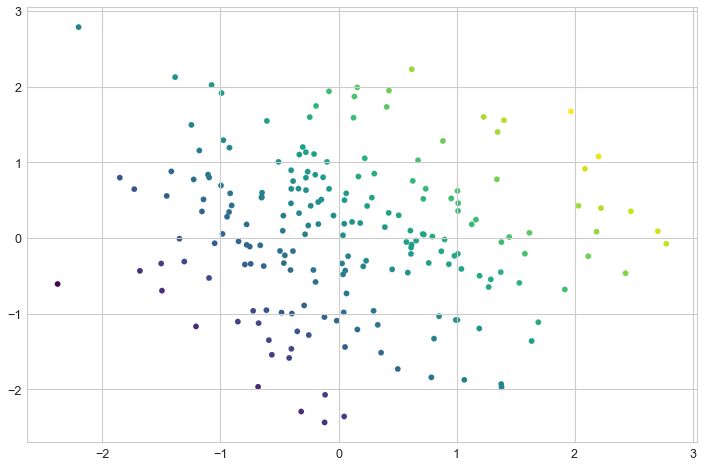

In [54]:
# Create datasets
X, y = make_regression(
    n_samples = 200,
    n_features = 2,
    n_informative = 2,
    n_targets = 1,#
    #bias = 0.1,
    noise=0,
    random_state=4
)

# Training data
plt.scatter(x = X[:,0], y = X[:,1], c = y)

In [55]:
nn = NN(input_size = X.shape[1], output_size = 1, layers = [8, 8, 8], activation_functions = [BasicActivation]*4)

In [56]:
# Use Genetical Algorithims to train weights
import pygad

# Get correct number of parameters
parameters = 0
for weight in nn.info["weights"]:
    parameters += np.product(weight.shape)

In [57]:
def array2ndarray(parameters, weights):
    """
    Function to convert a list to the weights of of the neural network.
    
    ::param parameters: (array)
    ::output: (list[array])
    """
    output = []
    for weight in weights:
        size = np.product(weight.shape)
        
        output += [np.reshape(parameters[:size], weight.shape)]
        parameters = parameters[size:]
    return output

In [58]:
class MeanSquareError():
    """
    Mean Square Error loss
    """
    def __init__(self):
        """
        Initialise class
        """
        pass

    def loss(self, y_pred, y):
        """
        Loss Function.

        ::param y_pred: (array)
        ::param y: (array)
        """
        return sum((y*1 - y_pred)**2)/len(y)

    def derivative(self, y_pred, y):
        """
        Derivative of the Loss Function.

        ::param y_pred: (array)
        ::param y: (array)
        """
        return (-2/len(y))*(y*1 - y_pred)
        

In [59]:
mse = MeanSquareError()

def fitness_func(solution, solution_idx):
    nn.info["weights"] = array2ndarray(solution, nn.info["weights"])
    y_pred = self.predict(X)
    return -1*mse.loss(y_pred, y)

In [60]:
parameters

177

In [61]:
fitness_function = fitness_func

num_generations = 100
num_parents_mating = 10
gene_type=float

sol_per_pop = 100
num_genes = int(parameters)

init_range_low = -10
init_range_high = 10

parent_selection_type = "sss"
keep_parents = 2

crossover_type = "single_point"

mutation_type = "random"
mutation_percent_genes = 5

In [62]:
def on_fitness(ga_instance, population_fitness):
    print(f"{ga_instance} = Best Loss: {max(population_fitness)}")


In [63]:
ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_function,
                       sol_per_pop=sol_per_pop,
                       gene_type=gene_type,
                       num_genes=num_genes,
                       init_range_low=init_range_low,
                       init_range_high=init_range_high,
                       parent_selection_type=parent_selection_type,
                       keep_parents=keep_parents,
                       parallel_processing=128,
                       crossover_type=crossover_type,
                       mutation_type=mutation_type,
                       on_fitness = on_fitness,
                       mutation_percent_genes=mutation_percent_genes)


In [64]:
ga_instance.run()

<pygad.pygad.GA object at 0x00000260D78687C0> = Best Loss: -751016.6443721614
<pygad.pygad.GA object at 0x00000260D78687C0> = Best Loss: -751016.6443721614
<pygad.pygad.GA object at 0x00000260D78687C0> = Best Loss: -751016.6443721614
<pygad.pygad.GA object at 0x00000260D78687C0> = Best Loss: -751016.6443721614
<pygad.pygad.GA object at 0x00000260D78687C0> = Best Loss: -751016.6443721614
<pygad.pygad.GA object at 0x00000260D78687C0> = Best Loss: -751016.6443721614
<pygad.pygad.GA object at 0x00000260D78687C0> = Best Loss: -751016.6443721614
<pygad.pygad.GA object at 0x00000260D78687C0> = Best Loss: -751016.6443721614
<pygad.pygad.GA object at 0x00000260D78687C0> = Best Loss: -751016.6443721614
<pygad.pygad.GA object at 0x00000260D78687C0> = Best Loss: -751016.6443721614
<pygad.pygad.GA object at 0x00000260D78687C0> = Best Loss: -751016.6443721614
<pygad.pygad.GA object at 0x00000260D78687C0> = Best Loss: -751016.6443721614
<pygad.pygad.GA object at 0x00000260D78687C0> = Best Loss: -7510

In [65]:
solution, solution_fitness, solution_idx = ga_instance.best_solution()
#print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))

print(f"Generic Prediction : {fitness_func([1]*int(parameters), None)}")


Fitness value of the best solution = -751016.6443721614
Generic Prediction : -751016.6443721614


In [66]:
nn.info["weights"] = array2ndarray(solution, self.weights)
y_pred = self.predict(X)

AttributeError: 'NN' object has no attribute 'weights'

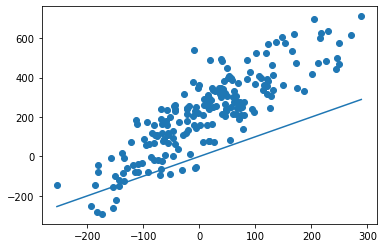

In [ ]:
plt.scatter(x = y, y = y_pred)
plt.plot([min(y), max(y)], [min(y), max(y)])